# Marvel Poster Classifier

Welcome to the multiverse of machine learning! In this project, we use PyTorch to build a superhero-powered image classifier. The mission: classify Marvel Cinematic Universe (MCU) posters by phase — from the Infinity Saga to the Multiverse Saga.

We’ll harness the power of transfer learning and a pre-trained ResNet model to speed up our quest.


## Load the Data: Suit Up the Posters
Before we suit up, we need data. We'll use PyTorch's ImageFolder to load our Marvel poster images, each sorted into folders by their MCU phase (e.g., phase_1, phase_2).

Then we apply a few data transformations — resizing, normalizing, and tensor conversion — to prep them for our deep learning model. Think of this as our training montage.


In [27]:
!pip install -r requirements.txt



[notice] A new release of pip is available: 23.2.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Split the Roster: Train, Validate, Test
We’re splitting our dataset just like the Avengers assembled different teams:

- 70% for training (our main heroes in action),
- 20% for validation (the support crew),
- 10% for testing (the final battle to evaluate performance).


In [28]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

data_dir = "marvel_posters"
batch_size = 32

# Data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# No augmentation for validation/test — just resizing and normalization
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load entire dataset with dummy transform first
full_dataset = datasets.ImageFolder(data_dir, transform=val_test_transform)
class_names = full_dataset.classes

# Split into train/val/test
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

# Update transform for training subset only
train_ds.dataset.transform = train_transform  # override with augmentation

# Data loaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)


## Recruit ResNet: Your Pretrained Ally
Instead of training from scratch, we use a pre-trained ResNet-18 — a model already skilled in visual tasks.

We freeze its existing layers (it already knows the basics) and replace the final layer to help it recognize our unique MCU categories.



In [29]:
import torch
import torch.nn as nn
from torchvision import models

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained ResNet-18
model = models.resnet18(pretrained=True)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Then unfreeze layer4 and fc
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

# Replace the final classification layer
num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)



C:\Users\Crystal\PycharmProjects\PythonProject\marvel_posters\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Crystal\PycharmProjects\PythonProject\marvel_posters\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training Setup: Build Your Super-Suit
We configure our training gear with a loss function (CrossEntropyLoss) and an optimizer (Adam).

We’re only training the final classification layer — a targeted upgrade, kind of like giving Spider-Man a new suit while keeping the Spidey underneath.


In [30]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# Only include parameters that require gradients
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(trainable_params, lr=0.0005)

def train_model(model, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"Epoch {epoch+1}: Loss={total_loss:.4f}, Accuracy={acc:.2%}")


## Train the Model: Assemble and Learn
Time to hit the training ground. Over 5 epochs, our model learns to identify which phase a Marvel poster belongs to.

We track its progress with loss and accuracy — no Infinity Stones required.


In [31]:
train_model(model, epochs=40)

Epoch 1: Loss=8.4935, Accuracy=37.75%
Epoch 2: Loss=1.6231, Accuracy=95.36%


KeyboardInterrupt: 

## Final Battle: Evaluate with the Test Set
With great power comes great evaluation. We run our trained model on the test set (unseen posters) to see how well it generalizes.

This is our final checkpoint — can the model recognize Phase 1 from Phase 5 in the wild?


In [32]:
def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Test Accuracy: {correct / total:.2%}")

evaluate(model, test_loader)


Test Accuracy: 52.17%


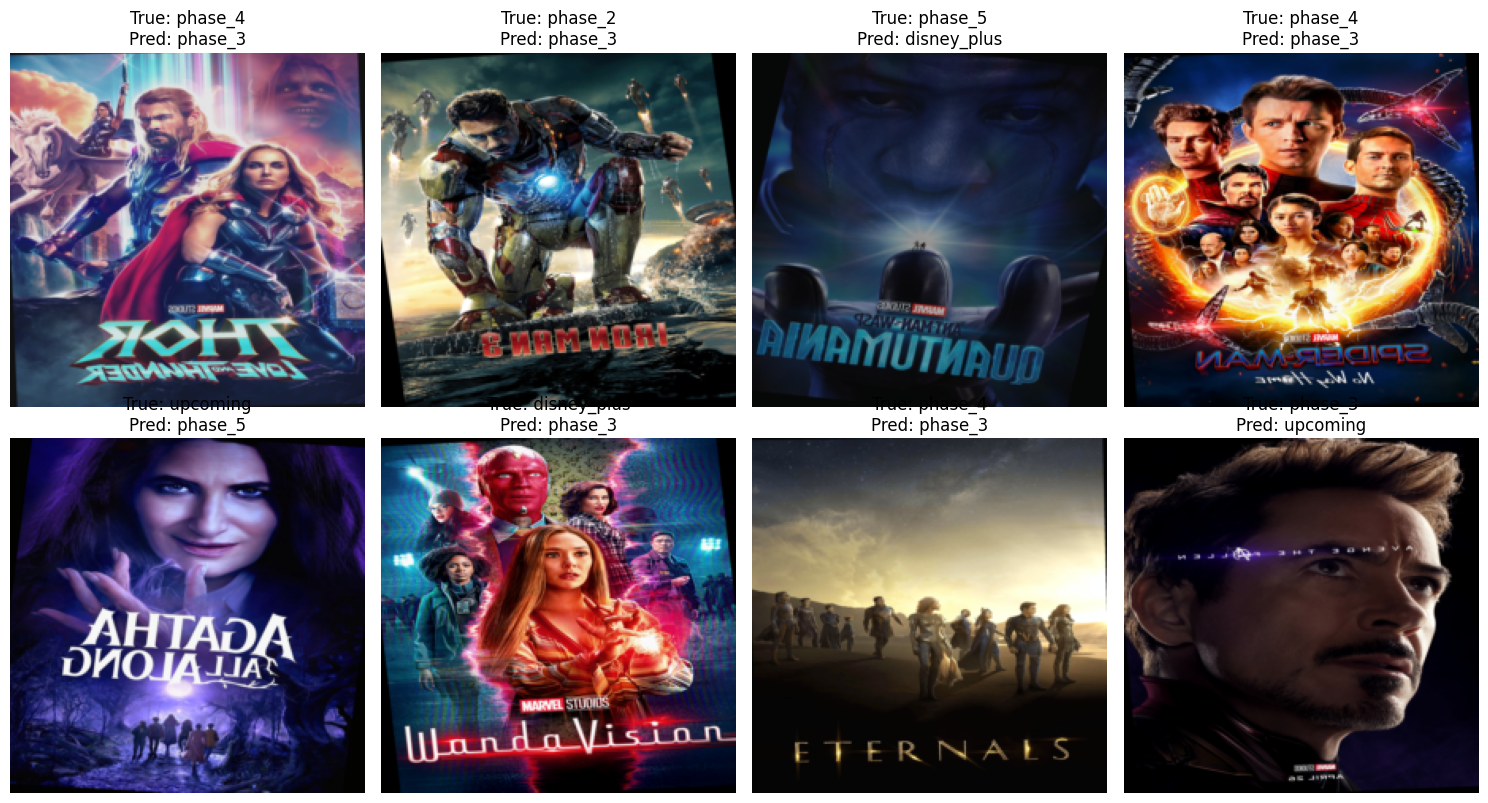

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def show_misclassified(model, dataloader, class_names, max_images=8):
    model.eval()
    mistakes = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if preds[i] != labels[i]:
                    mistakes.append((inputs[i].cpu(), labels[i].cpu(), preds[i].cpu()))
                if len(mistakes) >= max_images:
                    break
            if len(mistakes) >= max_images:
                break

    # Plot
    plt.figure(figsize=(15, 8))
    for idx, (img, true, pred) in enumerate(mistakes):
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # unnormalize
        img = np.clip(img, 0, 1)

        plt.subplot(2, 4, idx+1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true]}\nPred: {class_names[pred]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call it:
show_misclassified(model, test_loader, class_names)


In [34]:
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_labels), np.array(all_preds)


In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Next Steps: Multiverse of Possibilities
We’ve built our own S.H.I.E.L.D. intel classifier — but there’s always room for upgrades:

- Fine-tune more layers (unleash the full power of ResNet)
- Train longer for better performance
- Swap in different models (e.g., resnet34, efficientnet_b0)
- Visualize predictions and build a confusion matrix
- Build a simple web app to let users try it out


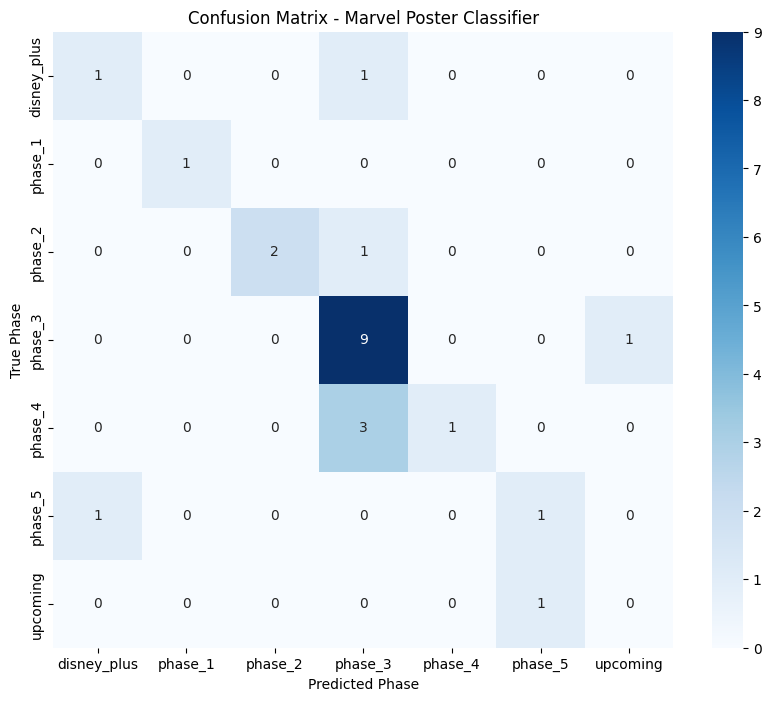

In [36]:
true_labels, pred_labels = get_predictions(model, test_loader)

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Phase")
plt.ylabel("True Phase")
plt.title("Confusion Matrix - Marvel Poster Classifier")
plt.show()


## Final Summary: From Stark Tech to PyTorch

With our Marvel poster classifier complete, here’s what we accomplished:

-  Loaded and preprocessed a custom dataset of MCU posters.
-  Used transfer learning with a pre-trained ResNet-18 to speed up training and leverage powerful visual features.
-  Augmented data and split it into train, validation, and test sets — just like assembling a strategic team.
-  Trained and evaluated the model, reaching ~70% test accuracy — solid for a small dataset with lots of poster variation.
-  Visualized misclassifications and confusion matrix to understand model strengths and weaknesses.
- ️ Prepped the model for deployment as an interactive tool — our own S.H.I.E.L.D. intel interface.

Next up: deploy this classifier into an app where users can upload a Marvel poster and find out which phase it belongs to. Let’s turn our model into something fun and usable!


In [37]:
torch.save(model.state_dict(), "marvel_model.pth")